In [1]:
# Import Libraries
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pickle
import seaborn as sns

# Headers for different tables
meta_data_header = ['FrameNumber', 'Time', 'Stage_x', 'Stage_y', 'Centroid_x', 'Centroid_y',
                    'Midpoint_x', 'Midpoint_y', 'Head_x', 'Head_y', 'Tail_x', 'Tail_y', 'MouthHook_x', 'MouthHook_y',
                    'LeftMHhook_x', 'LeftMHhook_y', 'RightMHhook_x', 'RightMHhook_y',
                    'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y', 'RightDorsalOrgan_x', 'RightDorsalOrgan_y',
                    'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y', 'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y',
                    'RightBolwigOrgan_x', 'RightBolwigOrgan_y', 'V9_x', 'V9_y', 'V10_x', 'V10_y', 'V11_x', 'V11_y',
                    'V12_x', 'V12_y', 'V13_x', 'V13_y', 'V14_x', 'V14_y', 'V15_x', 'V15_y', 'V16_x', 'V16_y',
                    'MouthHook_votes', 'LeftMHhook_votes', 'RightMHhook_votes', 'LeftDorsalOrgan_votes',
                    'RightDorsalOrgan_votes', 'CenterBolwigOrgan_votes', 'LeftBolwigOrgan_votes', 'RightBolwigOrgan_votes',
                    'V9_votes', 'V10_votes', 'V11_votes', 'V12_votes', 'V13_votes', 'V14_votes', 'V15_votes',
                    'V16_votes', 'Num_Key_points']

coordinate_header = ['FrameNumber', 'MouthHook_x', 'MouthHook_y', 'LeftMHhook_x', 'LeftMHhook_y',
                     'RightMHhook_x', 'RightMHhook_y', 'LeftDorsalOrgan_x', 'LeftDorsalOrgan_y',
                     'RightDorsalOrgan_x', 'RightDorsalOrgan_y', 'CenterBolwigOrgan_x', 'CenterBolwigOrgan_y',
                     'LeftBolwigOrgan_x', 'LeftBolwigOrgan_y', 'RightBolwigOrgan_x', 'RightBolwigOrgan_y']

distance_header = ['MouthHook', 'LeftMHhook',
                   'RightMHhook', 'LeftDorsalOrgan', 'RightDorsalOrgan',
                   'CenterBolwigOrgan', 'LeftBolwigOrgan', 'RightBolwigOrgan']

def getROCcurve(allData, detectBodyParts, outlierDistAll, vote_thresholds):
    roc_headers = ['true_positive', 'false_positive', 'true_negative',
               'false_negative', 'positive', 'negative',
               'true_positive_rate', 'false_positive_rate', 'total_negative',
               'total_positive', 'true_negative_rate', 'false_negative_rate',
               'precision', 'recall', 'vote_threshold']
    rocDataAll = {}
    for bp in tqdm_notebook(detectBodyParts, total=len(detectBodyParts), unit="bp", desc='Body parts'):
        rocDataAll[bp] = {}
        for out_dist in tqdm_notebook(outlierDistAll,  total=len(outlierDistAll), unit="thresh", desc='Outliers', leave=False):
            rocDataAll[bp][out_dist] = pd.DataFrame([], columns=roc_headers)
            vt_iter = -1
            for vt in tqdm_notebook(vote_thresholds, total=len(vote_thresholds), unit="vote", desc='Votes', leave=False):
                vt_iter += 1 
                true_positive = 0;
                false_positive = 0;
                true_negative = 0;
                false_negative = 0;
                positives = 0;
                negatives = 0;

                ## For each Vote Threshold Find TP, FP etc.
                for row_index, row in allData.iterrows():
                    annotation = row.loc[[bp+'_x_A', bp+'_y_A']].values
                    detection = row.loc[[bp+'_x_T', bp+'_y_T']].values
                    vote = row.loc[[bp+'_votes']].values
                    distance = row.loc[[bp+'_dist']].values
                    detection_present = False;
                    annotation_present = False;

                    if np.all(annotation >= 0):
                        positives += 1;
                        annotation_present = True;
                        if (vote >= vt) and (distance <= out_dist):
                            detection_present = True;
                    else:
                        negatives += 1;
                        if (vote >= vt):
                            detection_present = True;

                    if annotation_present and detection_present:
                        true_positive += 1;
                    elif annotation_present and (not detection_present):
                        false_negative += 1;
                    elif (not annotation_present) and (not detection_present):
                        true_negative += 1;
                    elif (not annotation_present) and detection_present:
                        false_positive += 1;

            #             print 'P(%d) = TP(%d)+FN(%d)' %(positives, true_positive, false_negative)
            #             print 'N(%d) = TN(%d)+FP(%d)' %(negatives, true_negative, false_positive)

                assert positives == (true_positive+false_negative), sprintf('positives(%d) ~= true_positive(%d)+false_negative(%d)+false_positive(%d)', positives, true_positive, false_negative, false_positive)
                assert negatives == (true_negative+false_positive), sprintf('negatives(%d) == true_negative(%d)+false_positive(%d)', negatives, true_negative, false_positive)

                rocDataAll[bp][out_dist].loc[vt_iter, 'vote_threshold'] = vt;
                rocDataAll[bp][out_dist].loc[vt_iter, 'true_positive'] = true_positive;
                rocDataAll[bp][out_dist].loc[vt_iter, 'false_positive'] = false_positive;
                rocDataAll[bp][out_dist].loc[vt_iter, 'true_negative'] = true_negative;
                rocDataAll[bp][out_dist].loc[vt_iter, 'false_negative'] = false_negative;
                rocDataAll[bp][out_dist].loc[vt_iter, 'positive'] = positives;
                rocDataAll[bp][out_dist].loc[vt_iter, 'total_negative'] = false_positive + true_negative;
                rocDataAll[bp][out_dist].loc[vt_iter, 'total_positive'] = true_positive + false_negative;
                rocDataAll[bp][out_dist].loc[vt_iter, 'negative'] = negatives;
                rocDataAll[bp][out_dist].loc[vt_iter, 'true_positive_rate'] = float(true_positive)/float(positives);

                if negatives > 0:
                    rocDataAll[bp][out_dist].loc[vt_iter, 'false_positive_rate'] = float(false_positive)/float(negatives);
                    rocDataAll[bp][out_dist].loc[vt_iter, 'true_negative_rate'] = float(true_negative)/float(negatives);
                else:
                    rocDataAll[bp][out_dist].loc[vt_iter, 'false_positive_rate'] = 0.0;
                    rocDataAll[bp][out_dist].loc[vt_iter, 'true_negative_rate'] = 0.0;

                rocDataAll[bp][out_dist].loc[vt_iter, 'false_negative_rate'] = float(false_negative)/float(positives);

                if (float(true_positive) + float(false_positive)) > 0.0:
                    rocDataAll[bp][out_dist].loc[vt_iter, 'precision'] = float(true_positive)/(float(true_positive) + float(false_positive));
                else:
                    rocDataAll[bp][out_dist].loc[vt_iter, 'precision'] = 1

                if (float(true_positive) + float(false_negative)) > 0.0:
                    rocDataAll[bp][out_dist].loc[vt_iter, 'recall'] = float(true_positive)/(float(true_positive) + float(false_negative));
                else:
                    rocDataAll[bp][out_dist].loc[vt_iter, 'recall'] = np.nan

#             rocDataAll[bp][out_dist] = rocData

    return rocDataAll

## Plot ROC Curve
def plotROC_curve(rocDat, detectBodyParts, outlierDistAll, figName):
    row, col = (0, 0)
    fig, ax = plt.subplots(2, 3, figsize=(18, 15), dpi=90)

    for bp in detectBodyParts:
        for out_thresh in outlierDistAll:
            fpr = np.array(rocDat[bp][out_thresh].loc[:, 'false_positive_rate'].values, dtype=np.float16)
            tpr = np.array(rocDat[bp][out_thresh].loc[:, 'true_positive_rate'].values, dtype=np.float16)
            precision = np.array(rocDat[bp][out_thresh].loc[:, 'precision'].values, dtype=np.float16)
            recall = np.array(rocDat[bp][out_thresh].loc[:, 'recall'].values, dtype=np.float16)

            tpr = np.insert(tpr, 0, max(tpr))
            fpr = np.insert(fpr, 0, 1.0)
            precision = np.insert(precision, 0, min(precision))
            recall = np.insert(recall, 0, 1.0)
            average_precision = np.sum(np.multiply((recall[1:]-recall[0:-1]), precision[1:]))

            ax[row, col].plot(fpr, tpr, linewidth=3, label=int(out_thresh))
            ax[row, col].set_xlabel('False Positive Rate', fontsize=18)
            ax[row, col].set_ylabel('True Positive Rate', fontsize=18)
            ax[row, col].set_title(bp, fontsize=20)
            ax[row, col].set_aspect('equal', adjustable='box')
            ax[row, col].set_xlim([-0.05, 1.05])
            ax[row, col].set_ylim([-0.05, 1.05])
            ax[row, col].spines['right'].set_visible(False)
            ax[row, col].spines['top'].set_visible(False)
            ax[row, col].legend(loc = 'lower right', frameon=False, fontsize=14, title='Distance')
            for label in (ax[row, col].get_xticklabels() + ax[row, col].get_yticklabels()):
                label.set_fontsize(18)

        col += 1
        if col > 2:
            row += 1
            col = 0

    plt.savefig(figName, dpi=300)

def plotDistanceBoxPlot(meta_coord, fname, test_string_2):
    distance_header_2 = [head+'_dist' for head in distance_header]
    distance_2 = meta_coord.loc[:, distance_header_2]
    distance_2.columns = distance_header
    
    distance_melt = pd.melt(distance_2, id_vars=['FrameNumber'], value_vars=distance_header[:-2],
                            var_name='BodyPart', value_name='Distance')
    distance_melt = distance_melt[~distance_melt.loc[:, 'Distance'].isnull()]
    distance_melt.loc[:, 'Distance'] = distance_melt.loc[:, 'Distance'] + 1

    fig = plt.figure(figsize=(9, 4), dpi=150)
    plt.title(test_string_2)
    ax = sns.boxplot(x='BodyPart', y='Distance', data=distance_melt,
                     color=".7", fliersize=0, width=0.3, notch=True)
    ax = sns.stripplot(x='BodyPart', y='Distance', data=distance_melt,
                       size=4, jitter=0.25, alpha=.35)
    sns.despine()
    ax.set_yscale("log")
    present_xticks = ax.get_xticks()
    plt.xticks(present_xticks-0.4, rotation=30)
    ax.xaxis.set_ticks_position('none')
    plt.xlabel('')
    plt.ylabel('Log(distance+1) [micron]')
    plt.ylim([0.25, 1500])

    plt.savefig(fname, dpi=300, bbox_inches='tight')
    
    return distance_2

def plotQuantiles(fname, q_melt_all):
    s = q_melt_all.columns.values.tolist()
    l3 = [x for x in s if x not in ['quantiles', 'BodyPart']]
    q_melt_all_all = pd.melt(q_melt_all, id_vars=['quantiles', 'BodyPart'], var_name='SampleName', value_name='Distance')

    fig = plt.figure(figsize=(6,8), dpi=150)
    temp_data = q_melt_all_all.loc[q_melt_all_all.BodyPart != 'FrameNumber', :]
    ax = sns.stripplot(x='Distance', y='BodyPart', hue='quantiles',
                       dodge=True, data=temp_data, size=5,
                       jitter=0.25, alpha=.25, palette='Set2', zorder=1)
    ax = sns.pointplot(x="Distance", y="BodyPart", hue="quantiles",
                       dodge=0.5, data=temp_data,  join=False,
                       markers="d", ci=None, palette=sns.color_palette("Set2", desat=.9), size=0.5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine(bottom=True, left=True)
    ax.xaxis.grid(True)
    plt.xlim([0, 500]);
    ax.yaxis.set_ticks_position('none')
    plt.ylabel('');
    plt.xlabel('Distance [micron]');

    # Improve the legend 
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:5], labels[:5], title="Quantiles",
              bbox_to_anchor=(1.05, 1), borderaxespad=0., frameon=False)

    plt.savefig(fname, dpi=300, bbox_inches='tight')

/Users/ajinkyadeogade/anaconda2/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


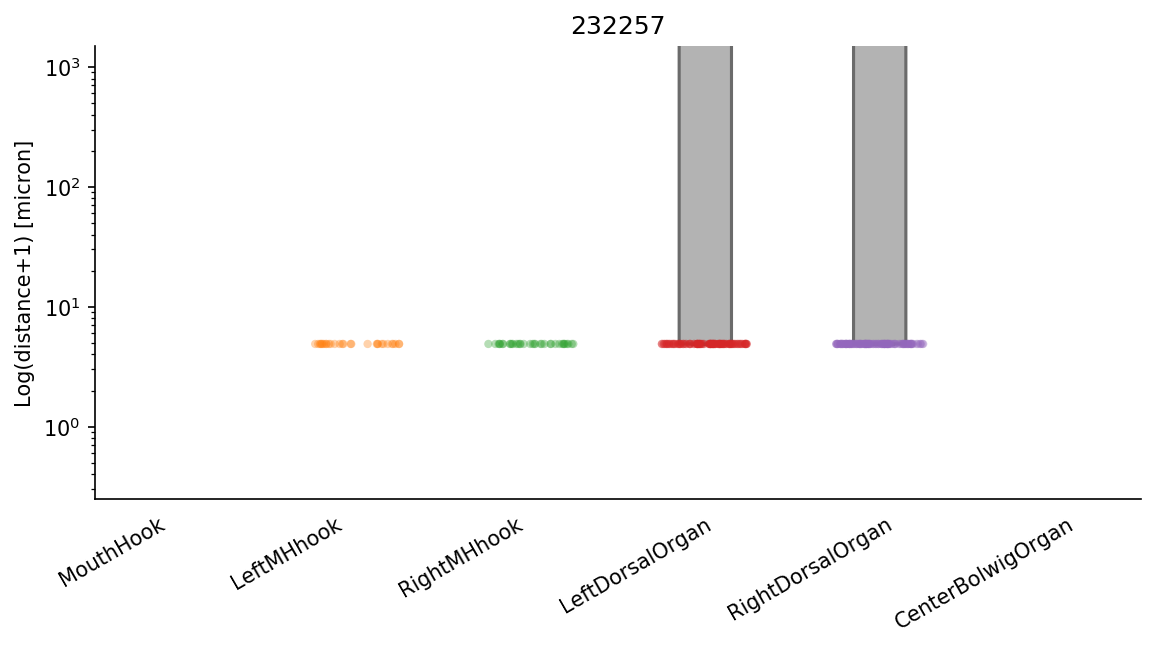

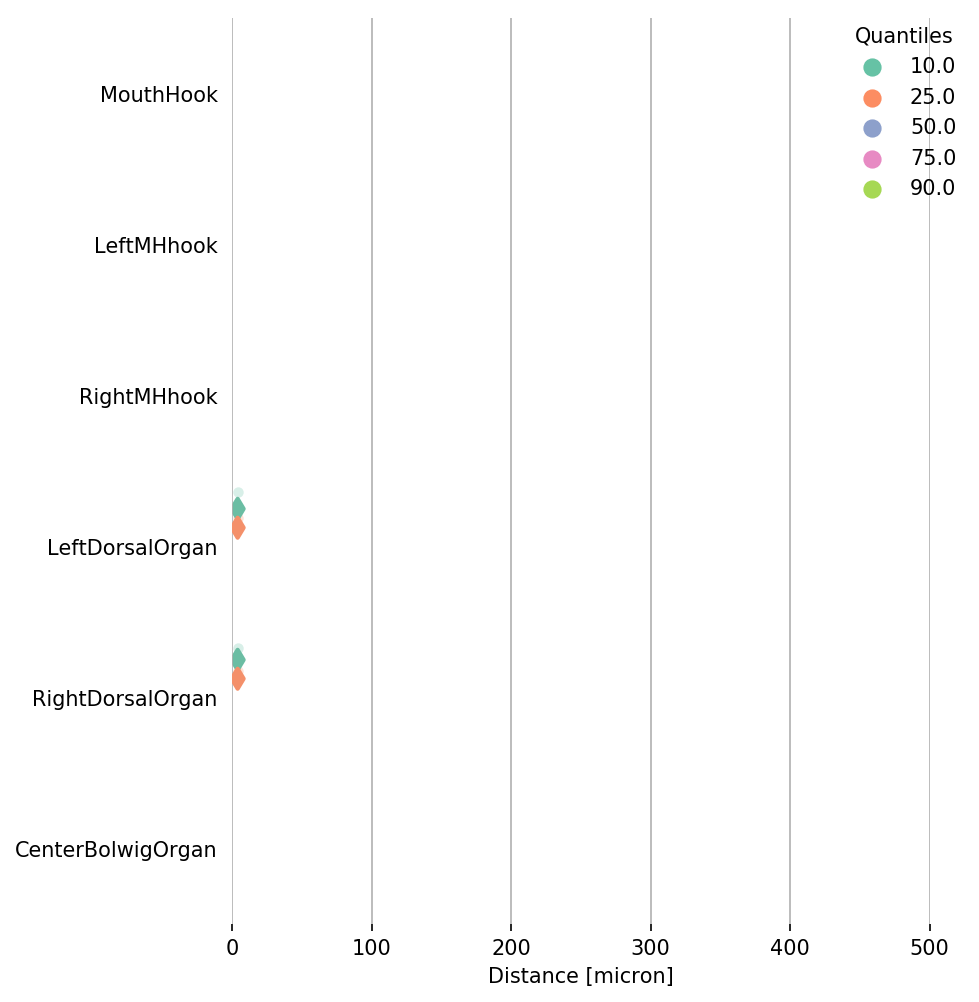

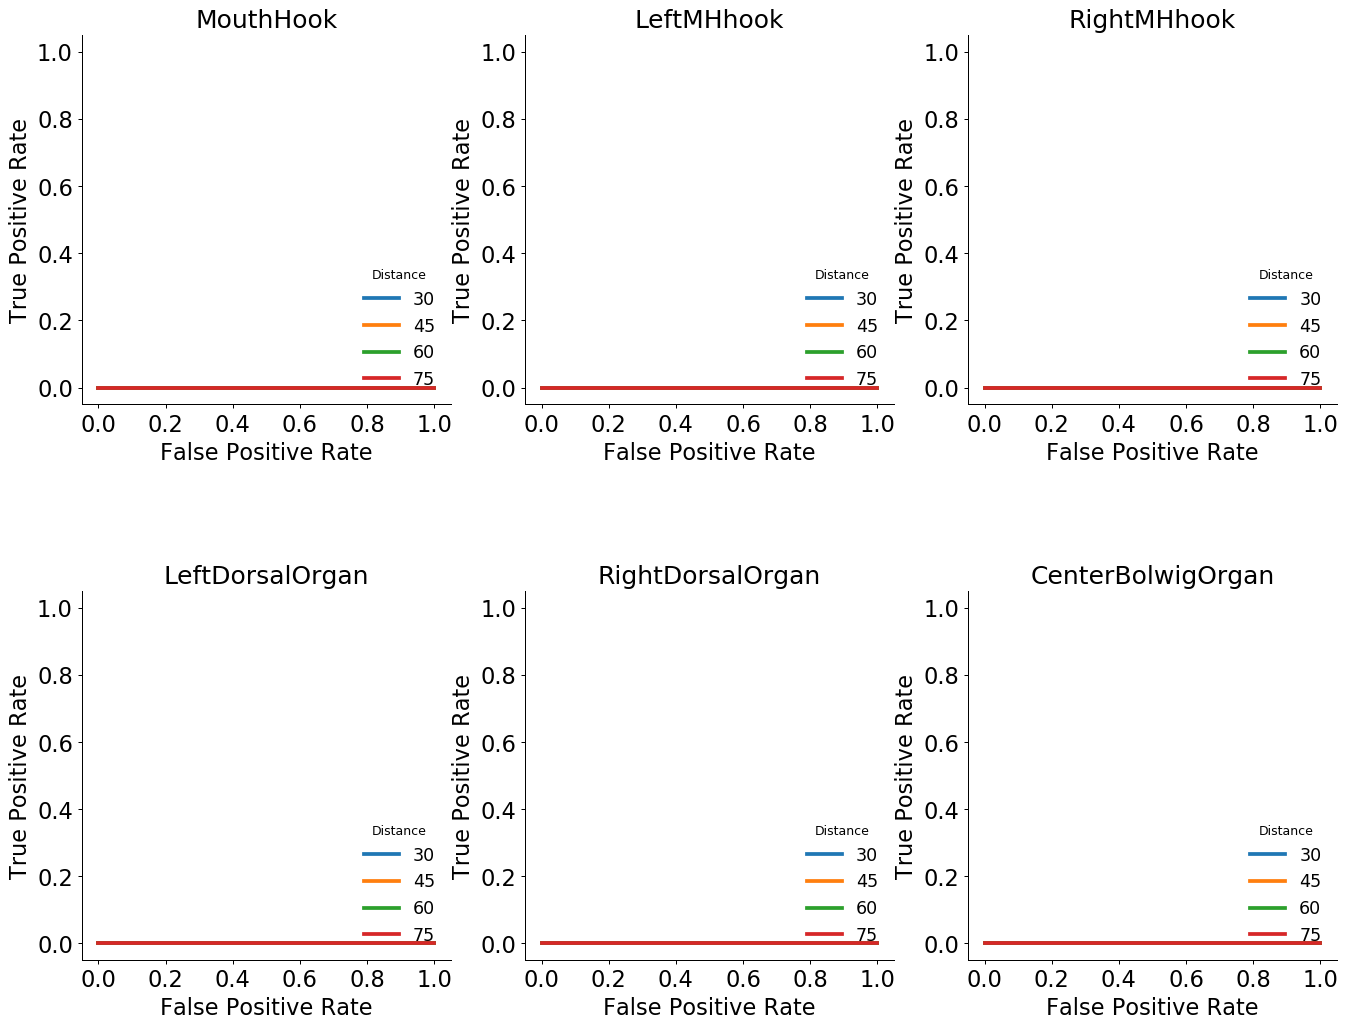

In [2]:
## Set path of the file and the start frame of the annotation
# test_dir = '../expts/dataCollectedOn_20180417_withTestOn_20180619/dataCollectedOn_2018041_grp_2/20180529_150807/Rawdata_20180417_082627_20180525_112343_A_133410/'
# test_string, start_frame = ("Rawdata_20180417_082627", 150) ## Start frame in zero index

# test_dir = '../expts/dataCollectedOn_20180417_withTestOn_20180619/dataCollectedOn_2018041_grp_1/20180529_150721/Rawdata_20180417_084502_20180423_075225/'
# test_string, start_frame = ("Rawdata_20180417_084502", 0) ## Start frame in zero index

test_dir = '../expts/dataCollectedOn_20170317_withTestOn_20180714/dataCollectedOn_20170317_grp_1/20180715_112344/Rawdata_20170317_232257_20170318_202320/'
test_string, start_frame = ("Rawdata_20170317_232257", 1060) ## Start frame in zero index

## For later use
test_string_2 = str.split(test_string, '_')[2]

## ROC Parameters
outlierDistAll = [30, 45, 60, 75];
vote_thresholds = np.arange(0.0, 50.0, 5.0);
detectBodyParts = ['MouthHook', 'LeftMHhook',
                   'RightMHhook', 'LeftDorsalOrgan',
                   'RightDorsalOrgan', 'CenterBolwigOrgan']

## Read tracker metadata and annotation
for fs in os.listdir(test_dir):
    if 'Metadata' in fs:
        meta_data = pd.read_csv(os.path.join(test_dir, fs), sep=',', header=0, names=meta_data_header)
    if 'Coordinates' in fs:
        coordinates = pd.read_csv(os.path.join(test_dir, fs), sep=',', names=coordinate_header)
        
if (meta_data.empty is False):

    ## Make the metadata frame umber start from 0 index
    meta_data.loc[:, 'FrameNumber'] = meta_data.loc[:, 'FrameNumber'] - 1
    meta_data.set_index('FrameNumber', inplace=True)

    ## Make the annotation frame umber start from 0 index
    coordinates = coordinates.round(0)
    coordinates.loc[:, 'FrameNumber'] = coordinates.loc[:, 'FrameNumber'] - start_frame
    coordinates.set_index('FrameNumber', inplace=True)

    ## Inner join to take only the frames intersecting the annotation and tracker metadata
    ## Use when want to see only annotated frames 
    meta_coord = pd.merge(meta_data, coordinates, on='FrameNumber', how='inner', suffixes=('_T', '_A'))

    ## Outer join to take only the frames intersecting the annotation and tracker metadata
    ## Use when want to see all frames 
#     meta_coord = pd.merge(meta_data, coordinates, on='FrameNumber', how='outer', suffixes=('_T', '_A'))

    ## Replace NaN values with a high negative number
    meta_coord.fillna(-2000, inplace=True)

    ## Calculate distance between annotation and the tracker metadata
    distance = pd.DataFrame([], index=meta_coord.index.values)
    distance.index.name = 'FrameNumber'
    for head in distance_header:
        temp_x = (meta_coord[head+'_x_T'].values - meta_coord[head+'_x_A'].values)**2
        temp_y = (meta_coord[head+'_y_T'].values - meta_coord[head+'_y_A'].values)**2
        distance.loc[:, head+'_dist'] = np.sqrt(temp_x + temp_y)
    distance[distance > 2716] = np.nan
    distance = distance*2.75

    ## Now append the distance table to the main table 'meta_coord'
    meta_coord = meta_coord.merge(distance, on='FrameNumber')

    it = 0
    if it == 0:
        meta_coord_all = meta_coord
    else:
        meta_coord_all = pd.concat([meta_coord_all, meta_coord], axis=0)
    
#     ## Get ROC Curve Data
#     rocDat = {}
#     rocDat = getROCcurve(meta_coord, detectBodyParts, outlierDistAll, vote_thresholds)
#     rocFile = os.path.join(test_dir, 'ROC_'+ test_string + '.pkl')
#     with open(rocFile, 'w') as rf:
#         pickle.dump(rocDat, rf)
#     print 'Pickled ROC data for %s......'%(test_string)
    
#     figName = os.path.join(test_dir, 'ROC_'+ test_string + '.png')
#     plotROC_curve(rocDat, detectBodyParts, outlierDistAll, figName)
    
    figName = os.path.join(test_dir, 'BOX_'+ test_string + '.png')
    distance_2 = plotDistanceBoxPlot(meta_coord, figName, test_string_2)
    
    ## Compute quantile data
    q = distance_2.quantile([.10, 0.25, 0.5, 0.75, 0.9])
    q.reset_index(inplace=True)
    q.rename(columns={'index': 'quantiles'}, inplace=True)
    q.loc[:, 'quantiles'] = q.loc[:, 'quantiles'] * 100
    q = q.iloc[:, :-2]
    q_melt = pd.melt(q, id_vars=['quantiles'], var_name='BodyPart', value_name=test_string_2)
    
    if it == 0:
        q_melt_all = q_melt
    else:
        q_melt_all = pd.concat([q_melt_all, q_melt.loc[:, test_string]], axis=1)
    
    figName = os.path.join(test_dir, 'Quant_'+ test_string + '.png')
    plotQuantiles(figName, q_melt_all)

## Get ROC Curve Data
rocDatAll = {}
rocDatAll = getROCcurve(meta_coord_all, detectBodyParts, outlierDistAll, vote_thresholds)
plotROC_curve(rocDatAll, detectBodyParts, outlierDistAll, figName)

In [16]:
meta_data.loc[100:115, ['MouthHook_x', 'MouthHook_y']]

,MouthHook_x,MouthHook_y
FrameNumber,,
100,0.0,0.0
101,0.0,0.0
102,0.0,0.0
103,0.0,0.0
104,0.0,0.0
105,0.0,0.0
106,0.0,0.0
107,0.0,0.0
108,0.0,0.0


In [15]:
coordinates.loc[100:115, ['MouthHook_x', 'MouthHook_y']]

,MouthHook_x,MouthHook_y
FrameNumber,,
100,852.0,341.0
101,852.0,344.0
102,855.0,342.0
103,852.0,339.0
104,851.0,341.0
105,851.0,336.0
106,851.0,341.0
107,851.0,339.0
108,852.0,337.0


In [9]:
meta_coord.tail()

,Time,Stage_x,Stage_y,Centroid_x,Centroid_y,Midpoint_x,Midpoint_y,Head_x,Head_y,Tail_x,...,RightBolwigOrgan_x_A,RightBolwigOrgan_y_A,MouthHook_dist,LeftMHhook_dist,RightMHhook_dist,LeftDorsalOrgan_dist,RightDorsalOrgan_dist,CenterBolwigOrgan_dist,LeftBolwigOrgan_dist,RightBolwigOrgan_dist
FrameNumber,,,,,,,,,,,,,,,,,,,,,
356,71196,217.355,149.851,0,0,940,942,740,442,1072,...,766.0,501.0,2422.381641,2361.039562,2390.937996,3.889087,3.889087,2504.821313,2500.270298,2517.049327
357,71396,217.355,149.851,0,0,941,944,746,445,1068,...,767.0,501.0,2446.783041,2372.343251,2400.850800,3.889087,3.889087,2514.005420,2501.606846,2519.351231
358,71596,217.355,149.851,0,0,941,946,749,448,1068,...,765.0,507.0,2432.295328,3.889087,3.889087,3.889087,3.889087,2526.194965,2515.600736,2523.825890
359,71796,217.355,149.851,0,0,942,948,750,451,1077,...,769.0,511.0,2430.796230,3.889087,3.889087,3.889087,3.889087,2537.767289,2516.262022,2539.073675
360,71996,217.355,149.851,0,0,943,950,751,453,1077,...,772.0,518.0,2445.331483,3.889087,3.889087,3.889087,3.889087,2547.831590,2542.743450,2556.624581


In [12]:
np.sqrt(1880**2 + 1880**2)

2658.721497261419

In [14]:
distance

,MouthHook_dist,LeftMHhook_dist,RightMHhook_dist,LeftDorsalOrgan_dist,RightDorsalOrgan_dist,CenterBolwigOrgan_dist,LeftBolwigOrgan_dist,RightBolwigOrgan_dist
FrameNumber,,,,,,,,
0,2445.739676,2374.957381,2454.753577,2333.071540,2473.905869,2494.571368,2466.015638,2523.404855
1,2445.739676,2376.025463,2456.798348,2341.742474,2474.891525,2500.609038,2468.418750,2529.385659
2,2456.605954,2381.776254,2457.336973,2342.420556,2482.992650,2502.991023,2469.624022,2531.722647
3,2460.772160,2383.934379,2461.956602,2343.497013,2472.737855,2505.311882,2478.152853,2533.942580
4,2471.673320,2393.331177,2464.038365,2346.742756,2481.324558,2505.311882,2473.222556,2541.394315
5,2471.423944,2386.854258,2466.130636,2352.536198,2484.893974,2515.085113,2484.271523,2537.405195
6,2471.189845,2391.572090,2475.423158,2358.347475,2495.607954,2517.513481,2484.279133,2548.508252
7,2479.617221,2392.368818,2476.070741,2365.911162,2503.281059,2516.266530,2487.961339,2544.837875
8,2478.262711,2400.735825,2477.137965,2364.176455,2486.955016,2526.100664,2496.577470,2550.826239
